# Interpetable YOLOv8 Demo on BR35H Dataset

In [1]:
import os
import torch
from PIL import Image, ImageDraw, ExifTags
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from yolov8_interpretable import InterpretableYOLOTest

In [2]:
def load_model(model_path, model_class=None):
    # loading a custom model
    model = torch.load(model_path)
    model =  model['model'].float()
    model.eval()  # Set the model to evaluation mode
    return model

# Function to get the bounding box from the label file
def get_bounding_box_from_label(image_name, label_dir):
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))
    with open(label_path, 'r') as file:
        label = file.readline().strip().split()
    class_id, x_center, y_center, width, height = map(float, label)

    return [x_center, y_center, width, height]

def draw_bounding_box(image, bbox, target_size=(225, 225), original_size=(640, 640), color="red"):
    draw = ImageDraw.Draw(image)
    orig_width, orig_height = original_size
    target_width, target_height = target_size
    size = original_size[0]
    # YOLO format: [x_center, y_center, width, height]
    x_center, y_center, width, height = bbox


    x_center *= size
    y_center *= size
    width *= size
    height *= size



    x1 = x_center - (width / 2)
    y1 = y_center - (height / 2)
    x2 = x_center + (width / 2)
    y2 = y_center + (height / 2)

    draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
    return image


label_dir = '/home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/labels' 

In [3]:
# key dict that contains inference image with their augmented duplicates
key = {'y750.jpg' : ['y132.jpg', 'y105.jpg', 'y328.jpg', 'y451.jpg', 'y249.jpg', 'y349.jpg'], 'y788.jpg' : ['y140.jpg', 'y206.jpg', 'y356.jpg', 'y469.jpg', 'y416.jpg', 'y276.jpg'], 
       'y737.jpg' : ['y94.jpg', 'y318.jpg', 'y344.jpg', 'y238.jpg', 'y444.jpg', 'y176.jpg'] }

data_yaml_path = '/home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/data.yaml'
weights_path = '/home/alan/Documents/YOLOV8_interpretable/YOLOv8_weights/best.pt'
weights = load_model(weights_path, model_class=None)
target_layer_index = 210
inference_files = ['y750.jpg', 'y788.jpg', 'y737.jpg'] # inference image files
n_components = list(range(10, 75, 5)) # n_component values to be tested for pca
outcome = {10: 0, 15: 0, 20 : 0, 25 : 0, 30 : 0, 35 : 0, 40 : 0, 45 : 0, 50 : 0, 55 : 0, 60 : 0, 65: 0, 70 : 0} #dictionary to hold the number of matches between nearest neighbor results and key for each n_component

In [4]:
for component in n_components:
    for inference in inference_files:
        if(component==10):
            model = InterpretableYOLOTest(data_yaml_path, model=weights, target_layer_index=270, pca_components=component)
        elif(component==15):
            model = InterpretableYOLOTest(data_yaml_path, model=weights, target_layer_index=200, pca_components=component)
        else:
            model = InterpretableYOLOTest(data_yaml_path, model=weights, target_layer_index=target_layer_index, pca_components=component)

        image_path = '/home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/test/images/' + inference
        k = 6
        result = model.single_image_inference(image_path, k=k)
        print(inference)
        for result in result['nearest_neighbors']:
            print(result, key[inference])
            if result in key[inference]:
                outcome[component] += 1
        print(str(component) + ':' + str(outcome[component]))

keys = list(outcome.keys())
values = list(outcome.values())
sorted_values_indices = np.argsort(values,kind='stable')
np.flip(sorted_values_indices)
sorted_outcome = {keys[i]: values[i] for i in sorted_values_indices} # dictionary sorted descending by number of matches of nearest neighbors to keys
print(sorted_outcome)








Collected features for 500 samples from layer at index '270'.
PCA reduced dimensions to 10 components.
complete
y750.jpg
y132.jpg ['y132.jpg', 'y105.jpg', 'y328.jpg', 'y451.jpg', 'y249.jpg', 'y349.jpg']
y105.jpg ['y132.jpg', 'y105.jpg', 'y328.jpg', 'y451.jpg', 'y249.jpg', 'y349.jpg']
y394.jpg ['y132.jpg', 'y105.jpg', 'y328.jpg', 'y451.jpg', 'y249.jpg', 'y349.jpg']
y260.jpg ['y132.jpg', 'y105.jpg', 'y328.jpg', 'y451.jpg', 'y249.jpg', 'y349.jpg']
y398.jpg ['y132.jpg', 'y105.jpg', 'y328.jpg', 'y451.jpg', 'y249.jpg', 'y349.jpg']
y290.jpg ['y132.jpg', 'y105.jpg', 'y328.jpg', 'y451.jpg', 'y249.jpg', 'y349.jpg']
10:2
Collected features for 500 samples from layer at index '270'.
PCA reduced dimensions to 10 components.
complete
y788.jpg
y140.jpg ['y140.jpg', 'y206.jpg', 'y356.jpg', 'y469.jpg', 'y416.jpg', 'y276.jpg']
y416.jpg ['y140.jpg', 'y206.jpg', 'y356.jpg', 'y469.jpg', 'y416.jpg', 'y276.jpg']
y469.jpg ['y140.jpg', 'y206.jpg', 'y356.jpg', 'y469.jpg', 'y416.jpg', 'y276.jpg']
y206.jpg ['y140

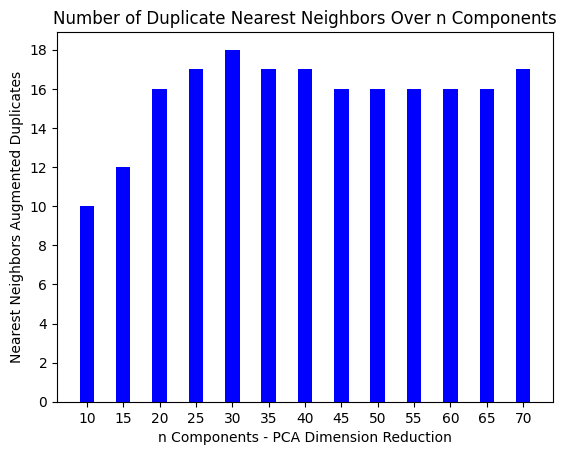

In [6]:
plt.bar(keys, values, tick_label=keys, width=2, color='blue')
plt.yticks(np.arange(0, max(values)+1, 2.0))
plt.xlabel('n Components - PCA Dimension Reduction')
plt.ylabel('Nearest Neighbors Augmented Duplicates')
plt.title('Number of Duplicate Nearest Neighbors Over n Components')
plt.savefig('/home/alan/Documents/YOLOV8_interpretable/images_and_graphs/Duplicate_Nearest_Neighbors.png', format='png', dpi=100, bbox_inches='tight')
plt.show()